In [1]:
import jax.tools.colab_tpu
jax.tools.colab_tpu.setup_tpu()
print(jax.__version__)

0.3.25


In [2]:
import jax
import flax
import jax.numpy as jnp
from flax import linen as nn
from jax import random
from tensorflow.keras import datasets

In [3]:
(train_images, train_labels), (test_images, test_labels) = datasets.mnist.load_data()

# Normalize and reshape the data using JAX's NumPy
train_images = jnp.expand_dims(train_images / 255.0, axis=-1).astype(jnp.float32)
test_images = jnp.expand_dims(test_images / 255.0, axis=-1).astype(jnp.float32)

11490434/11490434 [==============================] - 1s 0us/step


In [4]:
# Define the CNN model using Flax
class CNN(nn.Module):
    """
    A simple CNN model for MNIST classification.
    """
    @nn.compact
    def __call__(self, x: jnp.ndarray) -> jnp.ndarray:
        x = nn.Conv(features=32, kernel_size=(3, 3))(x)
        x = nn.relu(x)
        x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
        x = nn.Conv(features=64, kernel_size=(3, 3))(x)
        x = nn.relu(x)
        x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
        x = x.reshape((x.shape[0], -1))
        x = nn.Dense(features=256)(x)
        x = nn.relu(x)
        x = nn.Dense(features=10)(x)
        return nn.log_softmax(x)

In [5]:
key = random.PRNGKey(0)
model = CNN()
x = jnp.ones((1, 28, 28, 1), jnp.float32)
params = model.init(key, x)

In [6]:
# Initialize the optimizer
import optax
optimizer = optax.adam(0.001)
opt_state = optimizer.init(params)

In [7]:
from jax import grad, jit, value_and_grad
from jax.scipy.special import logsumexp

def loss_fn(params: dict, images: jnp.ndarray, labels: jnp.ndarray) -> float:
    """
    Computes the loss between the predicted labels and true labels.
    """
    logits = CNN().apply(params, images)
    logprobs = logits - logsumexp(logits, axis=-1, keepdims=True)
    return -jnp.mean(jnp.sum(logprobs * labels, axis=-1))

@jit
def train_step(opt_state: optax.OptState, params: dict, images: jnp.ndarray, labels: jnp.ndarray) -> tuple:
    """
    Performs a single training step.
    """
    loss, grads = value_and_grad(loss_fn)(params, images, labels)
    updates, new_opt_state = optimizer.update(grads, opt_state)
    new_params = optax.apply_updates(params, updates)
    return new_opt_state, new_params, loss

In [8]:
# Pre-compile functions
# Use a small subset of data to trigger JIT compilation
sample_images = jnp.ones((1, 28, 28, 1), jnp.float32)
sample_labels = jnp.zeros((1, 10), jnp.float32)
jit_loss_fn = jit(loss_fn)
jit_train_step = jit(train_step)

# Trigger JIT compilation
_ = jit_loss_fn(params, sample_images, sample_labels)
_ = jit_train_step(opt_state, params, sample_images, sample_labels)

In [9]:
from sklearn.model_selection import train_test_split

# Split the training data into training and validation sets
train_images, val_images, train_labels, val_labels = train_test_split(train_images, train_labels, test_size=0.2, random_state=42)

# One-hot encode labels
train_labels_onehot = jax.nn.one_hot(train_labels, 10)
val_labels_onehot = jax.nn.one_hot(val_labels, 10)

In [10]:
import pickle
import time

start_time = time.time()

# Initialize variables to keep track of best model and performance
best_val_loss = float('inf')
best_params = None
num_epochs = 5
batch_size = 64

# Lists to keep track of loss values for plotting
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    # Training loop
    train_loss_epoch = []
    for i in range(0, len(train_images), batch_size):
        batch_images = jnp.array(train_images[i:i + batch_size])
        batch_labels = jnp.array(train_labels_onehot[i:i + batch_size])
        opt_state, params, loss = train_step(opt_state, params, batch_images, batch_labels)
        train_loss_epoch.append(loss)

    avg_train_loss = jnp.mean(jnp.array(train_loss_epoch))
    train_losses.append(avg_train_loss)

    # Validation loop
    val_loss_epoch = []
    for i in range(0, len(val_images), batch_size):
        batch_images = jnp.array(val_images[i:i + batch_size])
        batch_labels = jnp.array(val_labels_onehot[i:i + batch_size])
        val_loss = loss_fn(params, batch_images, batch_labels)
        val_loss_epoch.append(val_loss)

    avg_val_loss = jnp.mean(jnp.array(val_loss_epoch))
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch + 1}, Train Loss: {avg_train_loss}, Val Loss: {avg_val_loss}")

    # Save best model
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_params = params

# Calculate the training time with JAX
end_time = time.time()
jax_training_time = end_time - start_time
print(f"Training time with JAX: {jax_training_time:.4f} seconds")

# Save the best model parameters to a file
with open('best_model_params.pkl', 'wb') as f:
    pickle.dump(best_params, f)

Epoch 1, Train Loss: 0.16865108907222748, Val Loss: 0.06649568676948547
Epoch 2, Train Loss: 0.050100091844797134, Val Loss: 0.043292369693517685
Epoch 3, Train Loss: 0.033147238194942474, Val Loss: 0.038670748472213745
Epoch 4, Train Loss: 0.02347264625132084, Val Loss: 0.042505547404289246
Epoch 5, Train Loss: 0.01709207519888878, Val Loss: 0.03702457249164581
Training time with JAX: 402.9136 seconds


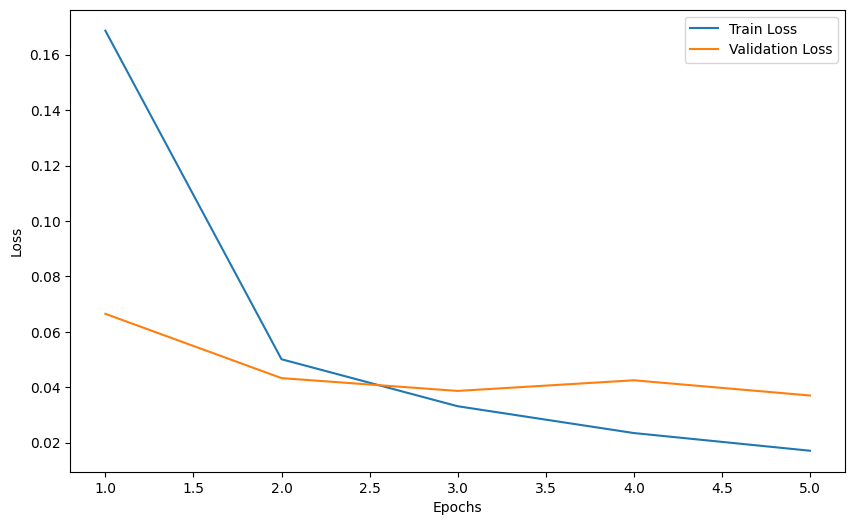

In [11]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [12]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Preparing data
(train_images, train_labels), (val_images, val_labels) = datasets.mnist.load_data()
train_images = train_images.reshape((60000, 28, 28, 1)).astype('float32') / 255
val_images = val_images.reshape((10000, 28, 28, 1)).astype('float32') / 255

train_labels = tf.keras.utils.to_categorical(train_labels, 10)
val_labels = tf.keras.utils.to_categorical(val_labels, 10)

# Creating the model
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    layers.AveragePooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.AveragePooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dense(10, activation='softmax')
])

# Compiling the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Measuring time for training
start_time = time.time()

# Fitting the model
history = model.fit(
    train_images, train_labels,
    epochs=5,
    batch_size=64,
    validation_data=(val_images, val_labels)
)

end_time = time.time()

non_jax_training_time = end_time - start_time

print(f"Training time without JAX: {non_jax_training_time:.4f} seconds")

Epoch 1/5
938/938 [==============================] - 120s 124ms/step - loss: 0.1787 - accuracy: 0.9480 - val_loss: 0.0603 - val_accuracy: 0.9796
Epoch 2/5
938/938 [==============================] - 118s 126ms/step - loss: 0.0549 - accuracy: 0.9836 - val_loss: 0.0424 - val_accuracy: 0.9858
Epoch 3/5
938/938 [==============================] - 115s 123ms/step - loss: 0.0377 - accuracy: 0.9880 - val_loss: 0.0344 - val_accuracy: 0.9886
Epoch 4/5
938/938 [==============================] - 116s 124ms/step - loss: 0.0279 - accuracy: 0.9913 - val_loss: 0.0266 - val_accuracy: 0.9915
Epoch 5/5
938/938 [==============================] - 114s 122ms/step - loss: 0.0215 - accuracy: 0.9931 - val_loss: 0.0293 - val_accuracy: 0.9905
Training time without JAX: 626.2345 seconds


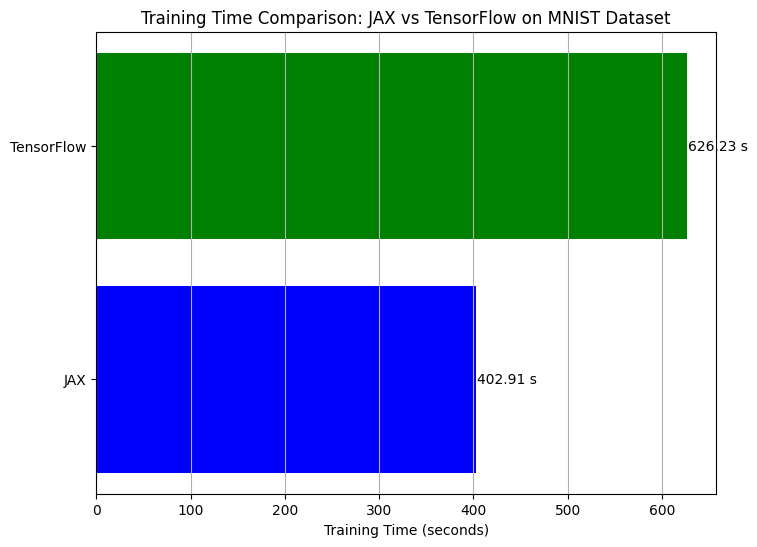

In [13]:
# Labels and corresponding values
labels = ['JAX', 'TensorFlow']
times = [jax_training_time, non_jax_training_time]

# Create the bar chart
plt.figure(figsize=(8, 6))
plt.barh(labels, times, color=['blue', 'green'])
plt.xlabel('Training Time (seconds)')
plt.title('Training Time Comparison: JAX vs TensorFlow on MNIST Dataset')
plt.grid(axis='x')

# Annotate with the exact times
for i, time in enumerate(times):
    plt.text(time + 1, i, f'{time:.2f} s', va='center')

plt.show()